In [53]:
import numpy as np
import os
import gc
import sys
import time
import random
import string
from time import strftime
from joblib import dump, load
import json
from sklearn.model_selection import ParameterGrid, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle

In [ ]:
'''
from IPython.utils.io import Tee

# Redirect all the outputs messages to the terminal and to a log file
logs_dir = './logs'
logfilename = logs_dir + strftime('/ipython_%Y-%m-%d_%H:%M:%S') + '.log' 
if not os.path.exists(logs_dir):
    os.makedirs(logs_dir)
    
sys.stdout = open('/dev/stdout', 'w')
Tee(logfilename, mode='w', channel='stdout')
'''

## Configuration

In [2]:
# Path where the data is stored
SOURCE_PATH = '../../../data'
# Directory inside SOURCE_PATH where the derived data is stored
DERIVED_DATA_DIR = '/derived_data'
# Experiment params
DATE_EXPERIMENT = '24022021'

# Number of force cells in the robotic leg
N_CELLS = 8

# Path where the results are stored
RESULTS_PATH = '../../../results'
# ID of the training and test data resulting from this notebook, stored in RESULTS_PATH
DATA_ID = '0003_11042021'
# Number of folds for cross-validation
CV = 5

print('Model training with data: ' + DATA_ID)

Model training with data: 0004_11042021


## Random Forest hyperparameters search

In [ ]:
# Hyperparameters search date
hs_date = '11042021'

# Parameters grid
param_grid = {
    'n_estimators': [100, 500, 1000, 5000, 10000],
    'max_depth': [5, 7, 10, 13, 15],
    'max_features': [0.3, 0.4, 0.5],
    'min_samples_leaf': [],
    'min_samples_split': []
}



param_grid_ls = list(ParameterGrid(param_grid))
param_grid_len = len(param_grid_ls)
print('Number of parameters combinations: {}'.format(param_grid_len))

for idx, params in enumerate(list(ParameterGrid(param_grid))):
    params_id = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))
    print('Parameters ({}) {}/{}'.format(params_id, idx + 1, param_grid_len))
    print(params)
    
    # Train the model with cross-validation
    cv_results = {}
    for fold_id in range(CV):
        print('Fold {}'.format(fold_id + 1))
        
        # Load data
        X_train = np.load(os.path.join(RESULTS_PATH, DATA_ID, 'data', 'X_train_cv{}_{}.npy'.format(fold_id + 1, DATA_ID)))
        X_test = np.load(os.path.join(RESULTS_PATH, DATA_ID, 'data', 'X_valid_cv{}_{}.npy'.format(fold_id + 1, DATA_ID)))
        Y_train = np.load(os.path.join(RESULTS_PATH, DATA_ID, 'data', 'Y_train_cv{}_{}.npy'.format(fold_id + 1, DATA_ID)))
        Y_test = np.load(os.path.join(RESULTS_PATH, DATA_ID, 'data', 'Y_valid_cv{}_{}.npy'.format(fold_id + 1, DATA_ID)))
        
        # Setup the model
        model = RandomForestRegressor(**params, random_state=0, n_jobs=-1, verbose=0)
        
        # Train the model
        t_start = time.time()
        model.fit(X_train, Y_train)
        t_end = time.time()
        
        # Get the scores
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)

        results = {
            'Train': {
                'MAE': mean_absolute_error(Y_train, train_preds, multioutput='raw_values'),
                'MSE': mean_squared_error(Y_train, train_preds, multioutput='raw_values'),
                'R2': r2_score(Y_train, train_preds, multioutput='raw_values')
            },
            'Test': {
                'MAE': mean_absolute_error(Y_test, test_preds, multioutput='raw_values'),
                'MSE': mean_squared_error(Y_test, test_preds, multioutput='raw_values'),
                'R2': r2_score(Y_test, test_preds, multioutput='raw_values')
            }       

        }
        
        for subset in ['Train', 'Test']:
            for f, force in enumerate(['Fx', 'Fy', 'Fz']):
                for loss in ['MAE', 'MSE', 'R2']:
                    scores = [results[subset][loss][i + f] for i in range(0, N_CELLS * 3, 3)]
                    cv_results[subset][force][loss]['mean'].append(np.mean(scores))
                    cv_results[subset][force][loss]['std'].append(np.std(scores))
            
    
    # Save the obtained results and its parameters into a JSON file
    rd = {}
    rd['id'] = params_id
    rd['fit_time'] = t_end - t_start
    rd['parameters'] = params
    rd['cv_results'] = cv_results
    
    with open(os.path.join(RESULTS_PATH, DATA_ID, 'RF_{}'.format(hs_date), 'RF_{}_{}.json'.format(hs_date, params_id)), 'w') as fp:
        json.dump(rd, fp)
    
    del model, results
    gc.collect()

In [44]:
model = RandomForestRegressor(n_estimators=100, max_depth=10, max_features=0.3, min_samples_leaf=0.0001, min_samples_split=100, random_state=0, n_jobs=-1, verbose=1)

model.fit(X_train, Y_train)

# Save the model
dump(model, os.path.join(SOURCE_PATH + DERIVED_DATA_DIR, DATE_EXPERIMENT, 'model_' + DATA_ID + '.joblib')) 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 10000 out of 

['../../../data/derived_data/24022021/model_0004_11042021.joblib']

In [49]:
param_grid = {
    'n_estimators': 100,
    'max_depth': 5,
    'max_features': 0.3,
    'min_samples_leaf': 0.001,
    'min_samples_split': 0.01
}

rf = RandomForestRegressor(**param_grid, random_state=0, n_jobs=-1, verbose=0)
cv_results = cross_validate(rf, X_train, Y_train, cv=5, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'])

cv_results

{'fit_time': array([6.7907443 , 7.19812536, 6.62564778, 7.2499671 , 7.99212527]),
 'score_time': array([0.21376133, 0.24804401, 0.20924664, 0.21007013, 0.14630222]),
 'test_neg_mean_absolute_error': array([-10.92583534, -10.90547106, -10.96789878, -10.88059255,
        -10.93899543]),
 'test_neg_mean_squared_error': array([-268.99136016, -267.71504157, -270.50506305, -265.71184639,
        -269.42290707]),
 'test_r2': array([0.51519234, 0.51012853, 0.50939587, 0.50747063, 0.51104126])}

In [45]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

results = {
    'Train': {
        'MAE': mean_absolute_error(Y_train, train_preds, multioutput='raw_values'),
        'MSE': mean_squared_error(Y_train, train_preds, multioutput='raw_values'),
        'R2': r2_score(Y_train, train_preds, multioutput='raw_values')
    },
    'Test': {
        'MAE': mean_absolute_error(Y_test, test_preds, multioutput='raw_values'),
        'MSE': mean_squared_error(Y_test, test_preds, multioutput='raw_values'),
        'R2': r2_score(Y_test, test_preds, multioutput='raw_values')
    }       
    
}

# Display the score for each axis of each force cell
# for subset in ['Train', 'Test']:
#     for f, force in enumerate(['Fx', 'Fy', 'Fz']):
#         for c in range(N_CELLS):
#             for loss in ['MAE', 'MSE', 'R2']:
#                 scores = [results[subset][loss][i + f] for i in range(0, N_CELLS * 3, 3)]
#                 print('{} {}{}{} {}: {:.4f}'.format(subset, force[0], c + 1, force[-1], loss, scores[c]))
# print('\n')

# Display the score mean and standard deviation of each axis
for subset in ['Train', 'Test']:
    for f, force in enumerate(['Fx', 'Fy', 'Fz']):
        for loss in ['MAE', 'MSE', 'R2']:
            scores = [results[subset][loss][i + f] for i in range(0, N_CELLS * 3, 3)]
            print(' '.join([subset, force, loss]) + ': {:.4f} ± {:.4f}'.format(np.mean(scores), np.std(scores)))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    5.4s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    8.5s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:   12.1s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:   16.4s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:   21.4s
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:   27.0s
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed:   33.4s
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed:   40.3s
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed:   48.4s
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed:   58.2s
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 10000 out of 10000 | elapsed:

Train Fx MAE: 4.8430 ± 1.4058
Train Fx MSE: 54.6418 ± 31.7206
Train Fx R2: 0.8710 ± 0.0294
Train Fy MAE: 4.8603 ± 3.1187
Train Fy MSE: 70.9768 ± 73.5019
Train Fy R2: 0.7952 ± 0.0695
Train Fz MAE: 6.2149 ± 2.1643
Train Fz MSE: 92.2576 ± 61.6399
Train Fz R2: 0.8853 ± 0.0322
Test Fx MAE: 10.5288 ± 3.7391
Test Fx MSE: 268.9060 ± 191.7128
Test Fx R2: 0.0425 ± 0.2441
Test Fy MAE: 10.5843 ± 7.6369
Test Fy MSE: 408.6703 ± 545.0741
Test Fy R2: 0.1016 ± 0.2824
Test Fz MAE: 13.8408 ± 5.5200
Test Fz MSE: 469.2427 ± 378.7298
Test Fz R2: -0.2127 ± 0.4691


[Parallel(n_jobs=8)]: Done 10000 out of 10000 | elapsed:   24.3s finished


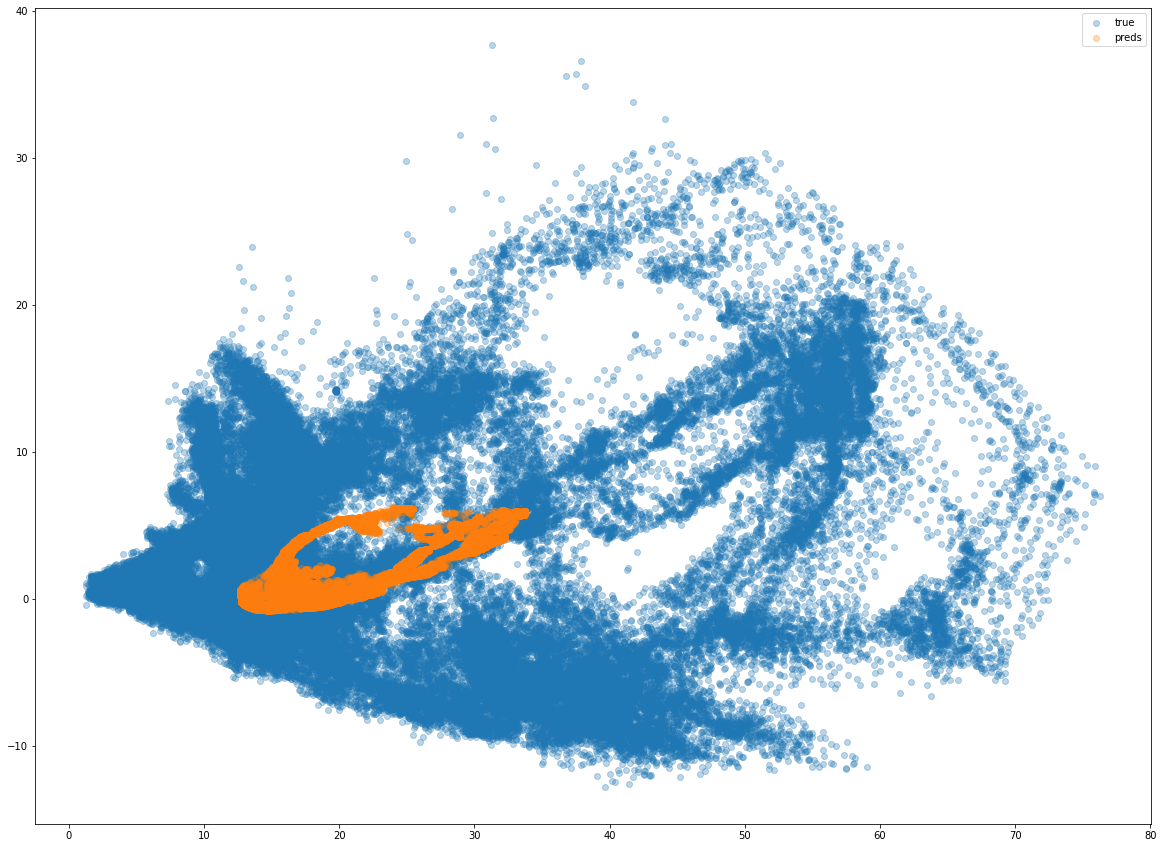

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.scatter(Y_train[:, 3], Y_train[:, 4], label='true', alpha=0.3)
plt.scatter(train_preds[:, 3], train_preds[:, 4], label='preds', alpha=0.3)
plt.legend()
plt.show()

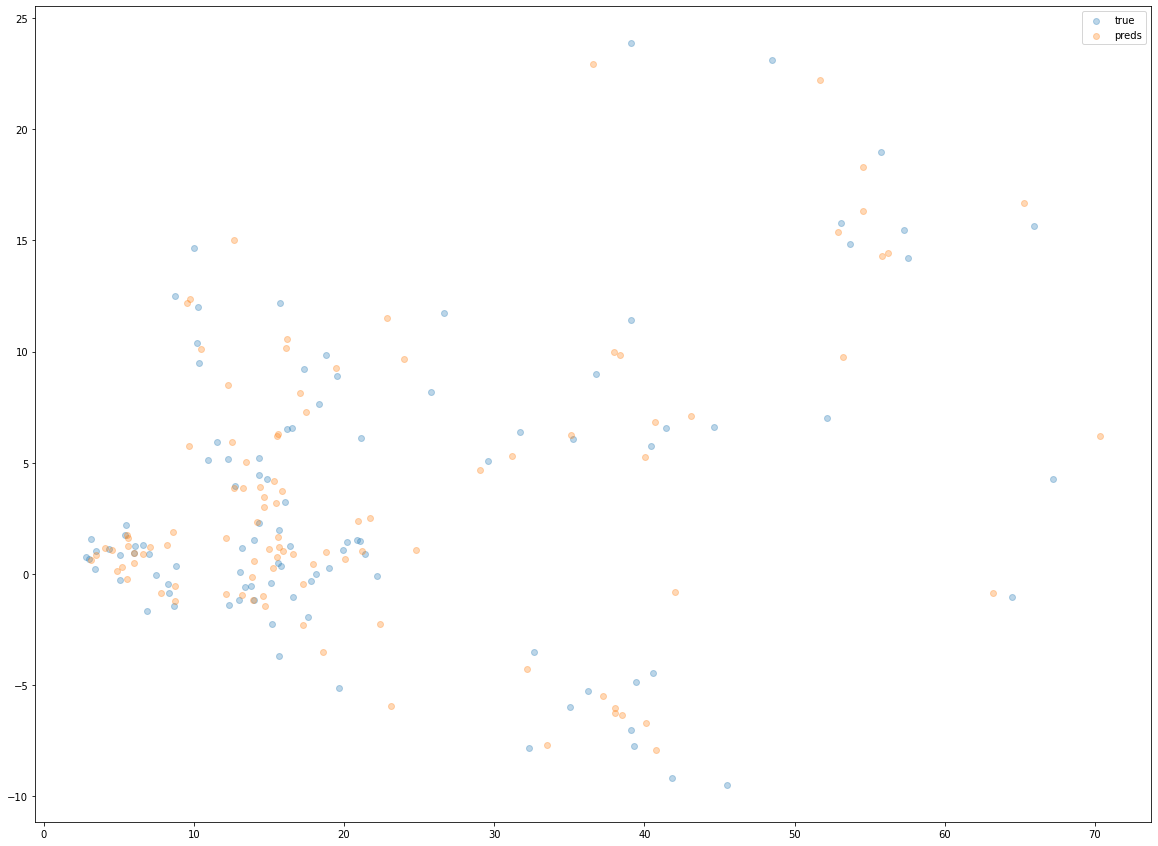

In [25]:
plt.figure(figsize=(20,15))
plt.scatter(Y_train[:100, 3], Y_train[:100, 4], label='true', alpha=0.3)
plt.scatter(train_preds[:100, 3], train_preds[:100, 4], label='preds', alpha=0.3)
plt.legend()
plt.show()

In [9]:
print(Y_test.shape)
print(test_preds.shape)

(34856, 24)
(34856, 24)


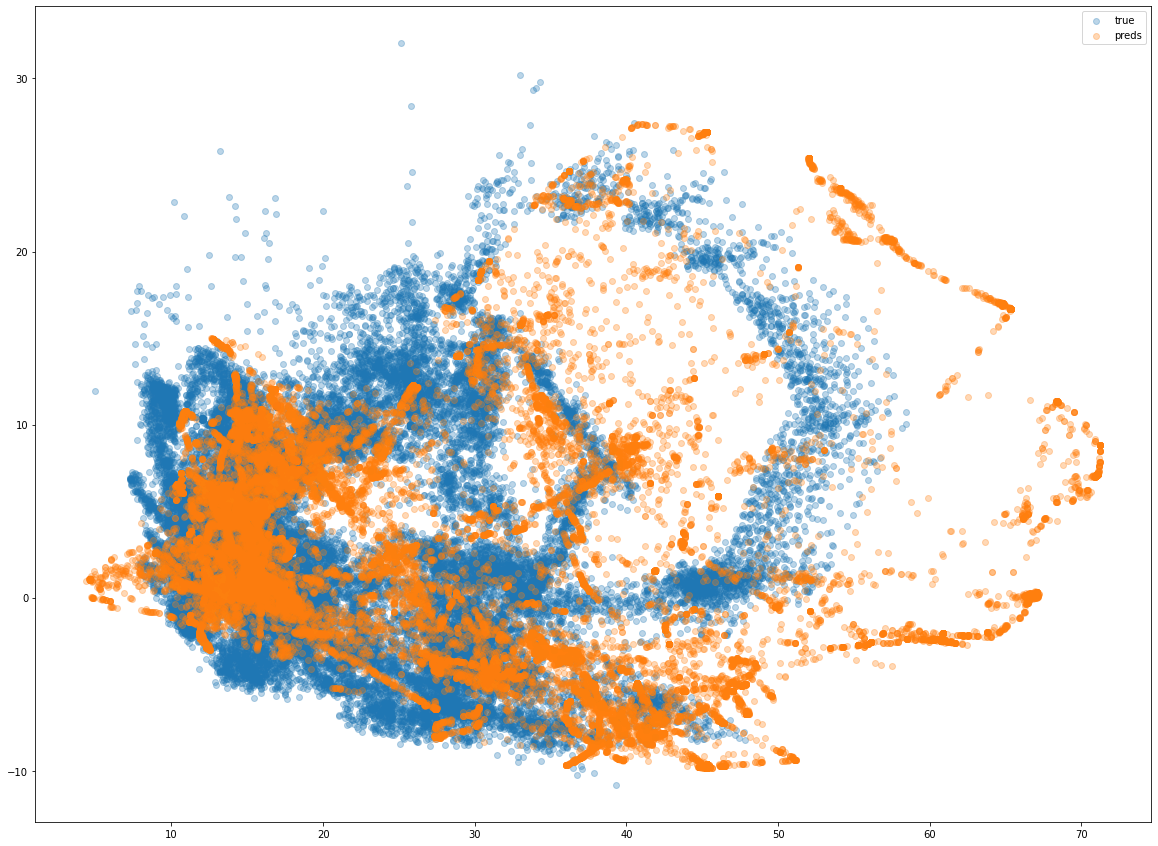

In [26]:
plt.figure(figsize=(20,15))
plt.scatter(Y_test[:, 3], Y_test[:, 4], label='true', alpha=0.3)
plt.scatter(test_preds[:, 3], test_preds[:, 4], label='preds', alpha=0.3)
plt.legend()
plt.show()

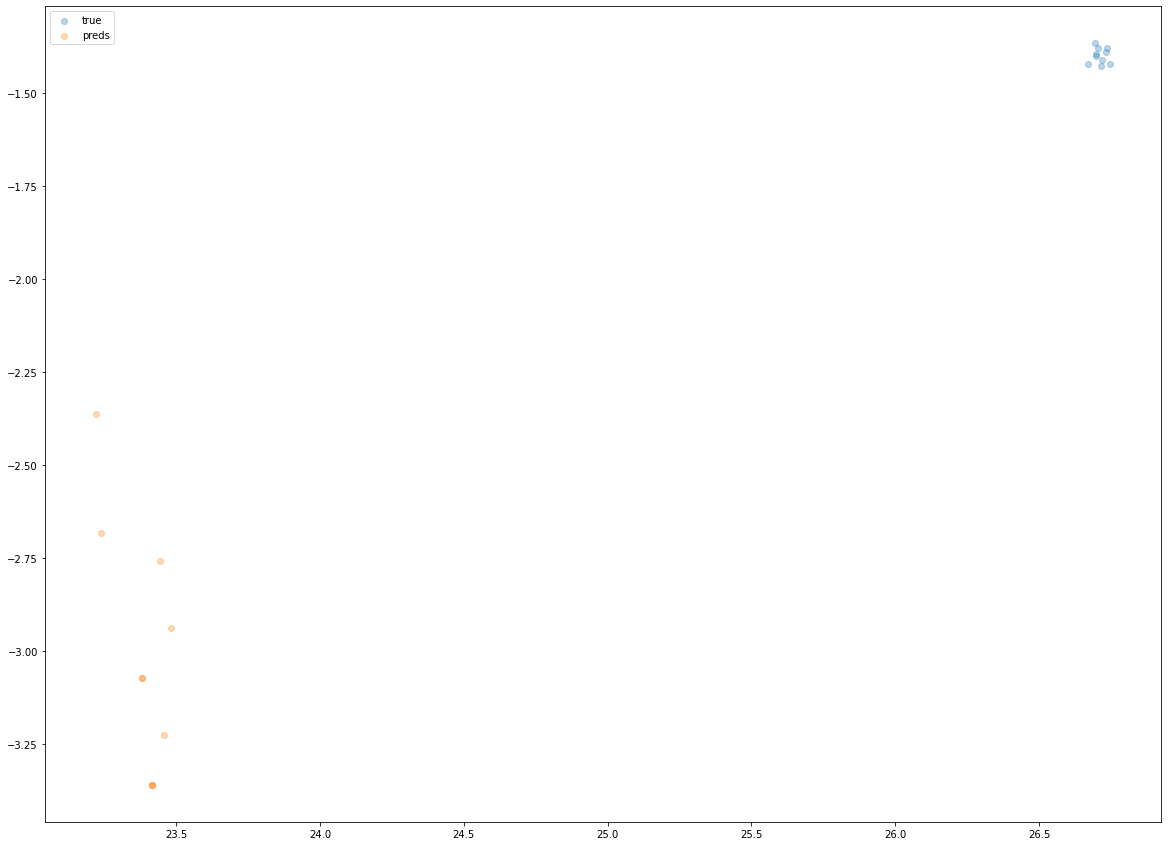

In [11]:
plt.figure(figsize=(20,15))
plt.scatter(Y_test[:10, 0], Y_test[:10, 1], label='true', alpha=0.3)
plt.scatter(test_preds[:10, 0], test_preds[:10, 1], label='preds', alpha=0.3)
plt.legend()
plt.show()

In [26]:
v, c = np.unique(test_preds[:, 0], return_counts=True)

v, c

(array([ 6.5530021 ,  6.68452037,  6.80502188, ..., 91.6852934 ,
        91.78776934, 91.80372969]),
 array([ 12,   5,   4, ...,  14,  26, 182]))

In [27]:
max(c)

1103